# Лабораторная работа №3
## $J_{N} |p_{ij}=1 | C_{max}$

**Задача**: Задача поиска расписания с минимальным временем окончания всех работ на
трех машинах, образующих систему *job shop* — рабочий цех; длительности
всех операций равны 1; у каждой работы свое множество операций; для каждой операции указана машина для ее выполнения.

Реализовать алгоритм решения с помощью библиотеки Pyomo и собственный жадный алгоритм для решения данной задачи, создать универсальный формат задания задачи.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import networkx as nx
from functools import reduce
import pandas as pd
import shutil
import sys
import json
import os.path
from pyomo.environ import *
from pyomo.gdp import *
from pyomo.contrib.latex_printer import latex_printer
import script

In [2]:
# Запись задачи в JSON формат
def WriteJson(dictionary: dict, name = "task.json"):
    with open(name, 'w') as f:
        json.dump(dictionary, f)

# Чтение задачи из JSON формата
def ReadJson(name = "task.json") -> dict:
    with open(name, 'r') as f:
        m = json.loads(f.read())
        return m

In [3]:
# Отрисовка диаграммы Ганта
def Gantt(JOBS, SCHEDULE={}, ax1=None, ax2=None):
    bw = 0.3

    idx = 0
    for j in sorted(JOBS.keys()):
        x = JOBS[j]['release']
        y = JOBS[j]['due']
        ax1.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='cyan', alpha=0.6)
        if j in SCHEDULE.keys():
            x = SCHEDULE[j]['start']
            y = SCHEDULE[j]['finish']
            ax1.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='red', alpha=0.5)
            ax1.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k')
            ax1.text((SCHEDULE[j]['start'] + SCHEDULE[j]['finish'])/2.0,idx,
                'Job ' + j, color='white', weight='bold',
                horizontalalignment='center', verticalalignment='center')
        idx += 1

    ax1.set_ylim(-0.5, idx-0.5)
    ax1.set_title('Job Schedule')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Jobs')
    ax1.set_yticks(range(len(JOBS)), JOBS.keys())
    ax1.grid()
    xlim = ax1.get_xlim()

    if SCHEDULE:
        for j in SCHEDULE.keys():
            if 'machine' not in SCHEDULE[j].keys():
                SCHEDULE[j]['machine'] = 1
        MACHINES = sorted(set([SCHEDULE[j]['machine'] for j in SCHEDULE.keys()]))

        for j in sorted(SCHEDULE.keys()):
            idx = MACHINES.index(SCHEDULE[j]['machine'])
            x = SCHEDULE[j]['start']
            y = SCHEDULE[j]['finish']
            ax2.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='red', alpha=0.5)
            ax2.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k')
            ax2.text((SCHEDULE[j]['start'] + SCHEDULE[j]['finish'])/2.0,idx,
                'Job ' + j, color='white', weight='bold',
                horizontalalignment='center', verticalalignment='center')
        ax2.set_xlim(xlim)
        ax2.set_ylim(-0.5, len(MACHINES)-0.5)
        ax2.set_title('Machine Schedule')
        ax2.set_yticks(range(len(MACHINES)), MACHINES)
        ax2.set_ylabel('Machines')
        ax2.grid()

# Подсчет метрик для решенной задачи
def Kpi(JOBS, SCHEDULE):
    KPI = {}
    KPI['Makespan'] = max(SCHEDULE[job]['finish'] for job in SCHEDULE)
    KPI['Max Pastdue'] = max(max(0, SCHEDULE[job]['finish'] - JOBS[job]['due']) for job in SCHEDULE)
    KPI['Sum of Pastdue'] = sum(max(0, SCHEDULE[job]['finish'] - JOBS[job]['due']) for job in SCHEDULE)
    KPI['Number Pastdue'] = sum(SCHEDULE[job]['finish'] > JOBS[job]['due'] for job in SCHEDULE)
    KPI['Number on Time'] = sum(SCHEDULE[job]['finish'] <= JOBS[job]['due'] for job in SCHEDULE)
    KPI['Fraction on Time'] = KPI['Number on Time']/len(SCHEDULE)
    return KPI

## Реализация в Pyomo

In [4]:
#Создание метода решения
def ScheduleMachines(JOBS, MACHINES):

    m = ConcreteModel()

    m.J = Set(initialize=JOBS.keys())
    m.M = Set(initialize=MACHINES)
    m.PAIRS = Set(initialize = m.J * m.J, dimen=2, filter=lambda m, j, k : j < k)

    BigM = (max([JOBS[j]['release'] for j in m.J]) + sum([JOBS[j]['duration'] for j in m.J]))
    
    m.start      = Var(m.J, bounds=(0, BigM))
    m.makespan   = Var(domain=NonNegativeReals)
    m.pastdue    = Var(m.J, domain=NonNegativeReals)
    m.early      = Var(m.J, domain=NonNegativeReals)

    m.ispastdue  = Var(m.J, domain=Binary)
    m.maxpastdue = Var(domain=NonNegativeReals)

    m.z = Var(m.J, m.M, domain=Binary)
    m.y = Var(m.PAIRS, domain=Binary)

    m.OBJ = Objective(expr = m.makespan, sense = minimize)

    m.c1 = Constraint(m.J, rule=lambda m, j:
            m.start[j] >= JOBS[j]['release'])
    m.c2 = Constraint(m.J, rule=lambda m, j:
            m.start[j] + JOBS[j]['duration'] + m.early[j] == JOBS[j]['due'] + m.pastdue[j])
    m.c3 = Constraint(m.J, rule=lambda m, j:
            sum(m.z[j,mach] for mach in m.M) == 1)
    m.c4 = Constraint(m.J, rule=lambda m, j:
            m.pastdue[j] <= BigM*m.ispastdue[j])
    m.c5 = Constraint(m.J, rule=lambda m, j:
            m.pastdue[j] <= m.maxpastdue)
    m.c6 = Constraint(m.J, rule=lambda m, j:
            m.start[j] + JOBS[j]['duration'] <= m.makespan)
    m.d1 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k:
            m.start[j] + JOBS[j]['duration'] <= m.start[k] + BigM*(m.y[j,k] + (1-m.z[j,mach]) + (1-m.z[k,mach])))
    m.d2 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k:
            m.start[k] + JOBS[k]['duration'] <= m.start[j] + BigM*((1-m.y[j,k]) + (1-m.z[j,mach]) + (1-m.z[k,mach])))

    #запись ограничений на выполнение работ пар (работа, машина)
    #проверяем бинарную принадлежность для каждой работы и машины в соответствии с таблицей
    i = 1
    for job in JOBS:
        setattr(m, f"c_{6 + i}", Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k: m.z[job, JOBS[job]["machine"]] == 1))
        i += 1

    #запись ограничений на последовательность работ
    #Просто запись что начало второй работы больше чем конец первой (В соответствии с таблицей)
    for job in JOBS:
        for dep in JOBS[job]["dependencies"]:
            setattr(m, f"p_{6 + i}", 
                    Constraint(
                        expr = m.start[job] >= (m.start[dep] + JOBS[dep]['duration']) 
                    ))
            i += 1

    SolverFactory('glpk',executable="C:\glpk\glpk-4.65\w32\glpsol.exe").solve(m)

    SCHEDULE = {}
    for j in m.J:
        SCHEDULE[j] = {
            'start': m.start[j](),
            'finish': m.start[j]() + JOBS[j]['duration'],
            'machine': [mach for mach in MACHINES if m.z[j,mach]()][0]
        }

    return SCHEDULE, m

## Жадный алгоритм

In [5]:
def Candidates(jobs: dict, machines: list, result: dict):
    candidates = {machine:[] for machine in machines}
        
    for job in jobs:
        if jobs[job]["dependencies"] and jobs[job]["dependencies"][0] not in result.keys():
            continue
        candidates[jobs[job]["machine"]].append((job, jobs[job]["dep_count"]))
        candidates[jobs[job]["machine"]].sort(key=lambda x: -x[1])
            
    return candidates

def Solve(jobs: dict, machines: list):
    result = {}
    start_time = jobs[next(iter(jobs))]["release"]
    duration = jobs[next(iter(jobs))]["duration"]
    
    i = 0
    while jobs:
        candidates = Candidates(jobs, machines, result)
        
        for machine in candidates:
            if not candidates[machine]:
                continue

            job = candidates[machine][0][0]
            result[job] = {
                'start': start_time + i * duration,
                'finish': start_time + (i + 1) * duration,
                'machine': machine,
            }
            jobs.pop(job)
        i += 1
    
    return result

---

In [6]:
def Test(name, verbose = False):
    DATA = ReadJson(name=name)
    
    #Задание спика машин
    MACHINES = DATA["MACHINES"]

    #Задание словаря работ
    JOBS_prev = DATA["JOBS"]
    JOBS = {}
    for job in JOBS_prev:
        for m, machine in enumerate(JOBS_prev[job]["sequence"], start=1):
            JOBS[job+f"_{m}"] = {
                'release': JOBS_prev[job]["release"], 
                'duration': JOBS_prev[job]["duration"], 
                'due': JOBS_prev[job]["due"], 
                'dependencies': [job+f"_{m-1}"] if m > 1 else [],
                'machine' : machine,
                'dep_count': len(JOBS_prev[job]["sequence"]) - m
            }

    SCHEDULE1, MODEL = ScheduleMachines(JOBS, MACHINES)
    SCHEDULE2 = Solve(JOBS.copy(), MACHINES)
    
    if not verbose:
        fig, ax = plt.subplots(3, 2, figsize=(15,18))
        fig.suptitle(f"{name}")
        ax[0][0].get_xaxis().set_visible(False)
        ax[0][0].get_yaxis().set_visible(False)
        ax[0][0].set_axis_off()
        ax[0][0].text(0.5, 0.5, f"Best: {Kpi(JOBS, SCHEDULE1)['Makespan']}\n"
                     f"Greedy: {Kpi(JOBS, SCHEDULE2)['Makespan']}")

        width = max(len(JOBS_prev[job]["sequence"]) for job in JOBS_prev)
        for jobId, job in enumerate(JOBS_prev, start=1):
            for m, machine in enumerate(JOBS_prev[job]["sequence"], start=1):
                x, y = m / (width + 1), jobId / (len(JOBS_prev) + 1)
                ax[0][1].text(x, y, f"${job}_{m}$", horizontalalignment='center', verticalalignment='center')
                ax[0][1].text(x, y + 0.07, f"${machine}$", horizontalalignment='center', verticalalignment='center')
                ax[0][1].add_patch(plt.Circle((x, y), 0.05, color='black', fill=False))
                if m < len(JOBS_prev[job]["sequence"]):
                    ax[0][1].add_patch(plt.Arrow(x + 0.05, y, 1 / (width + 1) - 0.1, 0, width= .04, color='black'))
                ax[0][1].set_aspect(1)
                ax[0][1].get_xaxis().set_visible(False)
                ax[0][1].get_yaxis().set_visible(False)
                ax[0][1].set_axis_off()
    
        Gantt(JOBS, SCHEDULE1, ax[1][0], ax[2][0]) 
        Gantt(JOBS, SCHEDULE2, ax[1][1], ax[2][1])
    
    return Kpi(JOBS, SCHEDULE1)['Makespan'], Kpi(JOBS, SCHEDULE2)['Makespan']

In [16]:
df = pd.DataFrame(columns=["Jobs count", "Machines count", "Path len", "Score", "my Score", "Delta"])
idx = 0
for jobs_count in range(2, 5):
    for machines_count in [2, 4, 6]:
        for path_len in [3, 5, 9]:
            idx += 1

            WriteJson(script.create_task(jobs_count, machines_count, path_len, 1, 0, 7))
            DATA = ReadJson(name="task.json")
            JOBS = DATA["JOBS"]

            s1, s2 = Test("task.json", verbose = True)

            df.loc[idx] = [jobs_count, machines_count, path_len, s1, s2, abs(s2-s1) if s1 is not None else None]

            print(f"[{idx}] Task with params: {[jobs_count, machines_count, path_len]} solved.")

[1] Task with params: [2, 2, 3] solved.
[2] Task with params: [2, 2, 5] solved.
[3] Task with params: [2, 2, 9] solved.
[4] Task with params: [2, 4, 3] solved.
[5] Task with params: [2, 4, 5] solved.
[6] Task with params: [2, 4, 9] solved.
[7] Task with params: [2, 6, 3] solved.
[8] Task with params: [2, 6, 5] solved.
[9] Task with params: [2, 6, 9] solved.
[10] Task with params: [3, 2, 3] solved.
[11] Task with params: [3, 2, 5] solved.
[12] Task with params: [3, 2, 9] solved.
[13] Task with params: [3, 4, 3] solved.
[14] Task with params: [3, 4, 5] solved.
[15] Task with params: [3, 4, 9] solved.
[16] Task with params: [3, 6, 3] solved.
[17] Task with params: [3, 6, 5] solved.
[18] Task with params: [3, 6, 9] solved.
[19] Task with params: [4, 2, 3] solved.
[20] Task with params: [4, 2, 5] solved.
[21] Task with params: [4, 2, 9] solved.
[22] Task with params: [4, 4, 3] solved.
[23] Task with params: [4, 4, 5] solved.
[24] Task with params: [4, 4, 9] solved.
[25] Task with params: [4

In [17]:
df

,Jobs count,Machines count,Path len,Score,my Score,Delta
1,2.0,2.0,3.0,4.0,4.0,0.0
2,2.0,2.0,5.0,6.0,6.0,0.0
3,2.0,2.0,9.0,10.0,10.0,0.0
4,2.0,4.0,3.0,4.0,4.0,0.0
5,2.0,4.0,5.0,6.0,6.0,0.0
6,2.0,4.0,9.0,9.0,9.0,0.0
7,2.0,6.0,3.0,3.0,3.0,0.0
8,2.0,6.0,5.0,7.0,7.0,0.0
9,2.0,6.0,9.0,4.0,4.0,0.0
10,3.0,2.0,3.0,6.0,6.0,0.0


### Пример:

(10.0, 10)

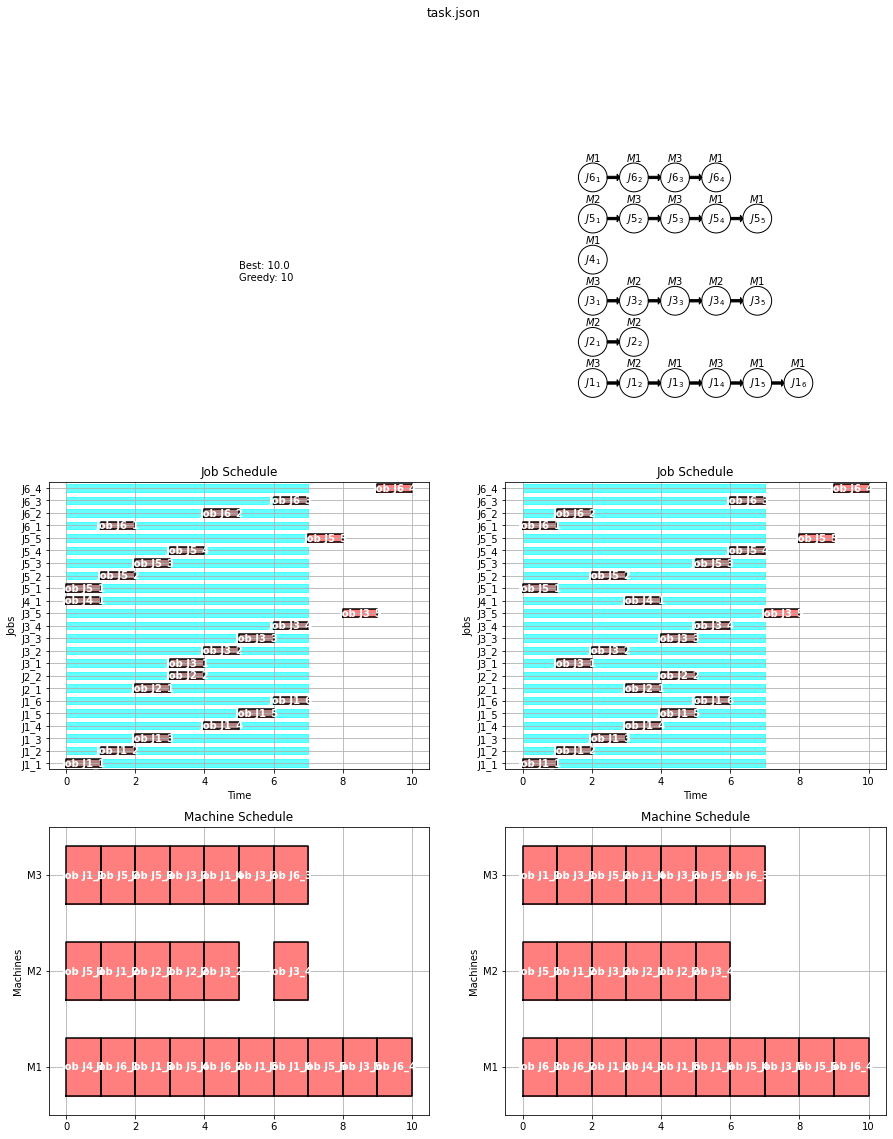

In [18]:
WriteJson(script.create_task(6, 3, 5, 1, 0, 7))
Test("task.json")